<a href="https://colab.research.google.com/github/doumoh/RIS_aided_communication/blob/main/OFDM_SIMO_RIS_OPTIMIZED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna==0.19")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

sionna.config.seed = 42 # Set seed for reproducible random number generation

In [1]:
!pip uninstall -y sionna tensorflow tensorflow-probability numpy
!pip install sionna==0.19 tensorflow tensorflow-probability numpy --upgrade
!pip uninstall -y mitsuba
!pip install mitsuba==3.5.0

Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
Found existing installation: tensorflow-probability 0.25.0
Uninstalling tensorflow-probability-0.25.0:
  Successfully uninstalled tensorflow-probability-0.25.0
Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of ipywidgets to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of ipywidgets to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 271.6/271.6 kB 22.9 MB/s eta 

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle

from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Conv2D, LayerNormalization
from tensorflow.nn import relu

from sionna.channel.tr38901 import Antenna, AntennaArray
from sionna.channel import OFDMChannel
from sionna.mimo import StreamManagement
from sionna.ofdm import ResourceGrid, ResourceGridMapper, RemoveNulledSubcarriers, ResourceGridDemapper
from sionna.utils import BinarySource, ebnodb2no, insert_dims, flatten_last_dims, log10, expand_to_rank
from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder
from sionna.mapping import Mapper, Demapper
from sionna.utils.metrics import compute_ber
from sionna.utils import sim_ber
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera
from sionna.channel import cir_to_ofdm_channel, subcarrier_frequencies, OFDMChannel, ApplyOFDMChannel, CIRDataset
from sionna.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.utils import compute_ber, ebnodb2no, PlotBER
from sionna.mimo import StreamManagement

In [3]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/rxx.xml'

Mounted at /content/drive


In [4]:
from sionna.rt import load_scene, Transmitter, Receiver, RIS, PlanarArray, \
                      r_hat, normalize, Camera
from sionna import PI

In [214]:


# Load scene
scene = load_scene(file_path)
# Configure antenna array for all transmitters
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="tr38901",
                             polarization="V")

# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="tr38901",
                             polarization="cross")

# Create transmitter
tx = Transmitter(name="tx",
                 position=[-4,1.5,1.5])

# Add transmitter
scene.add(tx)

width = 8 * scene.wavelength  # Width [m] for 16*16 RIS elements
num_rows = num_cols = int(width/(0.5*scene.wavelength))
ris = RIS(name="ris",
          position=[2,-3,2],
          orientation=[PI/2,0,0],
          num_rows=num_rows,
          num_cols=num_cols)

scene.add(ris)

# Create a receiver
rx = Receiver(name="rx",
              position=[2,5,2],
              orientation=[0,0,0])

# Add receiver
scene.add(rx)

source = tx.position
target = rx.position
#ris.phase_gradient_reflector(source, target)


In [ ]:
phase_profile_np = ris.phase_profile.values.numpy()
# Set all values to 180 initially
phase_profile_np[:] = PI # Switch ON
""" configuration for state (b) """
phase_profile_np[:, :,:4] = 0 # Switch OFF
phase_profile_np[:, :,8:12] = 0 # Switch OFF
# Convert back to a TensorFlow tensor and reassign
ris.phase_profile.values = tf.convert_to_tensor(phase_profile_np, dtype=tf.float32)

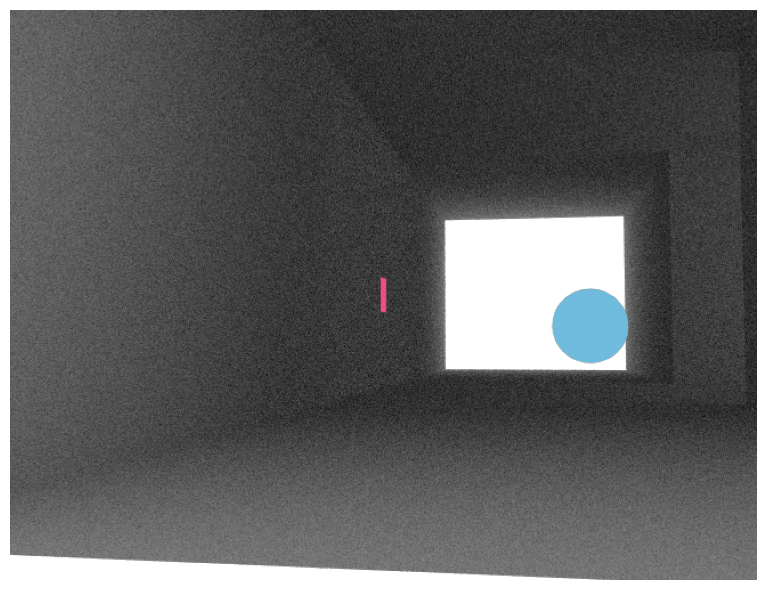

In [ ]:
scene.add(Camera("cam",
                         position=[20,0,1],
                         look_at=[2,-3,2]))
scene.render(camera="cam", num_samples=25);

In [215]:
from sionna.rt.solver_paths import SolverPaths # Import SolverPaths to modify the _ris_transition_matrices function
class CustomSolverPaths(SolverPaths):
    def _ris_transition_matrices(self, ris_paths, ris_paths_tmp):
        # Compute scattering coefficients
        sc = [tf.reduce_sum(r(), axis=0) for r in self._scene.ris.values()]
        sc = tf.concat(sc, axis=0)
        sc = sc[tf.newaxis, tf.newaxis, ...]


        # Coefficient calculation
        coef = tf.cast(4 * PI, self._rdtype)
        coef /= tf.reduce_prod(ris_paths_tmp.distances, axis=0)
        coef *= tf.cast(tf.sqrt(tx.power_dbm * 0.001 * 120 * PI * 2 * 66), self._rdtype)
        coef = tf.complex(coef, tf.cast(0, self._rdtype))

        # Differentiable phase decision: use magnitude of imag part
        imag_part = tf.math.imag(sc)

        # Sharpen sigmoid to approximate a step function: large scaling factor
        sharpness = 100000000.0  # Higher value = closer to hard decision
        phase_weight = tf.sigmoid(sharpness * imag_part)  # Step at imag_part = 0

        # Now interpolate between 0° for real (imag == 0) and 165° for complex (non-zero imag)
        phase_deg = phase_weight * 2 * 165.0 + (1 - phase_weight) * 0.0


        # Convert to radians and cast
        phase_rad = phase_deg * (np.pi / 180.0)
        phase_rad = tf.cast(phase_rad, self._rdtype)


        # Compute complex phase rotation
        sigma_eff_value = 0.001  # Scalar value
        sqrt_sigma = tf.sqrt(tf.cast(sigma_eff_value, self._rdtype))
        sqrt_sigma = tf.complex(sqrt_sigma, tf.cast(0, self._rdtype))  # Ensure sqrt_sigma is complex
        sigma_phi_matrix = sqrt_sigma * tf.exp(
            tf.complex(0.0, phase_rad)  # Ensure exp result is complex
        )

        # Apply coefficient modification with masking
        coef *= sigma_phi_matrix
        coef = tf.where(ris_paths.mask, coef, tf.cast(0, coef.dtype))

        # Create polarization-preserving transition matrices
        coef = coef[..., tf.newaxis, tf.newaxis]
        ris_mat_t = coef * tf.eye(2, batch_shape=[1, 1, 1], dtype=self._dtype)

        return ris_mat_t

In [216]:
scene._solver_paths = CustomSolverPaths(scene) # Replace to custom SolverPaths

In [223]:
# Create trainable variables for phase (continuous)
phase_var = tf.Variable(tf.zeros_like(ris.phase_profile.values), trainable=True)

# Define optimizer
optimizer = tf.keras.optimizers.Adam(0.01)
# Custumaze gradient so it still work in computation graph
@tf.custom_gradient
def binarize_phase(x):
    pi = tf.constant(np.pi, dtype=tf.float32)
    binary = tf.where(x > 0, pi, 0.0)         # Anything > 0 --> pi else 0
    def grad(dy):
        return dy * tf.cast(tf.logical_and(x > -1.5, x < 1.5), tf.float32) # Accept gradient between -1.5 and 1.5 ,other set to zero (no update)
    return binary, grad

def to_db(x):
    return 10*tf.math.log(x)/tf.math.log(10.)
# Training step
def train_step():
    with tf.GradientTape() as tape:
        # Apply binarized phase
        bin_phase = binarize_phase(phase_var)

        ris.phase_profile.values = bin_phase
        # Compute CIR and loss
        paths = scene.compute_paths()

        a = tf.squeeze(paths.cir()[0])
        a = tf.expand_dims(a, axis=-1)  # [2, 1] to match a_it

        path_gain = to_db(tf.reduce_mean(tf.reduce_sum(tf.abs(a)**2, axis=-1)))
        loss = -path_gain

    # Compute and apply gradients
    grads = tape.gradient(loss, [phase_var])
    optimizer.apply_gradients(zip(grads, [phase_var]))
    return path_gain, a

# Initialize accumulation tensor with correct shape (it depend on paths numbers)
a_it = tf.zeros([0, 2, 18, 1], dtype=tf.complex64)

# Training loop
num_iterations = 30
for i in range(num_iterations):
    path_gain, a = train_step()  # 'a' shape: [2, 18, 1]
    a_it = tf.concat([a_it, a[tf.newaxis]], axis=0)  # shape: [iteration, 2, 18, 1]

    if i % 10 == 0:
        print(f"Iteration {i}: Path Gain = {path_gain.numpy():.2f} dB")

Iteration 0: Path Gain = -60.32 dB
Iteration 10: Path Gain = -36.11 dB
Iteration 20: Path Gain = -36.36 dB


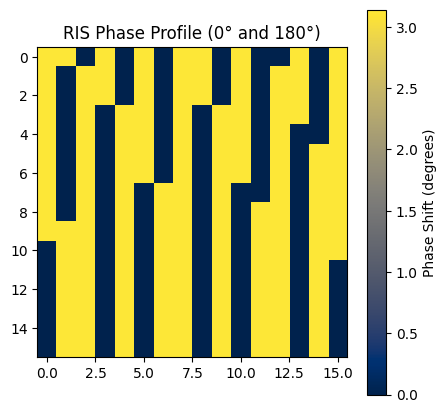

In [206]:
phase_profile = ris.phase_profile.values.numpy()
phase_profile = tf.squeeze(phase_profile, axis=0)  # remove batch dim
# Plot the phase profile
plt.figure(figsize=(5, 5))
plt.imshow(phase_profile, cmap="cividis", origin="upper")
plt.colorbar(label="Phase Shift (degrees)")
plt.title("RIS Phase Profile (0° and 180°)")
plt.show()

In [192]:
# ON / OFF phases
_phases = [0.0, np.pi]

# We need [1, 16, 16] -> [256] total elements phases
original_shape = ris.phase_profile.values.shape
flat_phases = tf.reshape(ris.phase_profile.values, [-1])
num_elements = flat_phases.shape[0]

# Start with all-zero phase
best_phases = tf.zeros_like(flat_phases)

def compute_path_gain(): # Fn to compute gain
    paths = scene.compute_paths()
    a = tf.squeeze(paths.cir()[0])
    a = tf.expand_dims(a, axis=-1)
    return 10 * tf.math.log(tf.reduce_mean(tf.reduce_sum(tf.abs(a)**2, axis=-1))) / tf.math.log(10.0)

# Iteratively optimize each RIS element
for idx in range(num_elements):
    best_gain = -np.inf
    best_phase = 0.0

    for phase in _phases:
        updated = tf.tensor_scatter_nd_update(best_phases, [[idx]], [phase])
        reshaped = tf.reshape(updated, original_shape)
        ris.phase_profile.values = reshaped
        gain = compute_path_gain()

        if gain > best_gain:
            best_gain = gain
            best_phase = phase
            print(best_gain)


    # Set best phase in flat tensor
    best_phases = tf.tensor_scatter_nd_update(best_phases, [[idx]], [best_phase])
    print(best_phase)
# Final config
ris.phase_profile.values = tf.reshape(best_phases, original_shape)
final_gain = compute_path_gain()
print(f"Final Path Gain: {final_gain.numpy():.2f} dB")


tf.Tensor(-63.015934, shape=(), dtype=float32)
tf.Tensor(-61.265812, shape=(), dtype=float32)
3.141592653589793
tf.Tensor(-61.265812, shape=(), dtype=float32)
0.0
tf.Tensor(-61.265812, shape=(), dtype=float32)
tf.Tensor(-59.782825, shape=(), dtype=float32)
3.141592653589793
tf.Tensor(-59.782825, shape=(), dtype=float32)
0.0
tf.Tensor(-59.782825, shape=(), dtype=float32)
tf.Tensor(-59.1498, shape=(), dtype=float32)
3.141592653589793
tf.Tensor(-59.1498, shape=(), dtype=float32)
0.0
tf.Tensor(-59.1498, shape=(), dtype=float32)
0.0
tf.Tensor(-59.1498, shape=(), dtype=float32)
tf.Tensor(-58.21285, shape=(), dtype=float32)
3.141592653589793
tf.Tensor(-58.21285, shape=(), dtype=float32)
0.0
tf.Tensor(-58.21285, shape=(), dtype=float32)
tf.Tensor(-57.256893, shape=(), dtype=float32)
3.141592653589793
tf.Tensor(-57.256893, shape=(), dtype=float32)
0.0
tf.Tensor(-57.256893, shape=(), dtype=float32)
tf.Tensor(-57.13533, shape=(), dtype=float32)
3.141592653589793
tf.Tensor(-57.13533, shape=(), dty

**Final Path Gain: -37.58 dB**

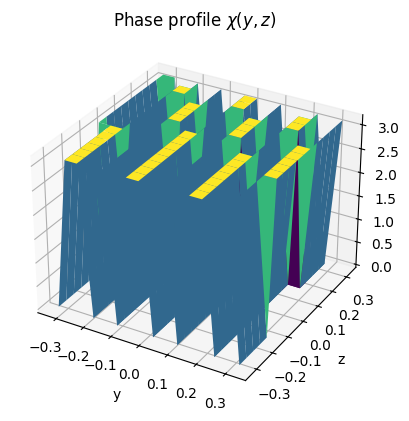

In [207]:
ris.phase_profile.show(0);

In [8]:
# SNR range for evaluation and training
ebno_db_min = -5.0
ebno_db_max = 10.0

## OFDM configuration
subcarrier_spacing = 30e3 # Hz
fft_size = 128 # Number of subcarriers
num_ofdm_symbols = 14 # Number of OFDM symbols
dc_null = True # Null the DC subcarrier
num_guard_carriers = [5, 6] # Number of guard carriers on each side
pilot_pattern = "kronecker" # Pilot pattern
pilot_ofdm_symbol_indices = [2, 11] # Index of OFDM symbols carrying pilots
cyclic_prefix_length = 0 # Simulation in frequency domain.

## Modulation and coding configuration
num_bits_per_symbol = 2 # QPSK
coderate = 0.5 # Coderate for LDPC code

## Neural receiver configuration
num_conv_channels = 12 # Number of convolutional channels for the convolutional layers forming the neural receiver

## Training configuration
training_batch_size = 48 # Training batch size
model_weights_path = "neural_receiver_weights" # Location to save the neural receiver weights once training is done

In [9]:
stream_manager = StreamManagement(np.array([[1]]), # Receiver-transmitter association matrix
                                  1)               # One stream per transmitter
resource_grid = ResourceGrid(num_ofdm_symbols = num_ofdm_symbols,
                             fft_size = fft_size,
                             subcarrier_spacing = subcarrier_spacing,
                             num_tx = 1,
                             num_streams_per_tx = 1,
                             cyclic_prefix_length = cyclic_prefix_length,
                             dc_null = dc_null,
                             pilot_pattern = pilot_pattern,
                             pilot_ofdm_symbol_indices = pilot_ofdm_symbol_indices,
                             num_guard_carriers = num_guard_carriers)

In [10]:
# Codeword length. It is calculated from the total number of databits carried by the resource grid, and the number of bits transmitted per resource element
n = int(resource_grid.num_data_symbols*num_bits_per_symbol)
# Number of information bits per codeword
k = int(n*coderate)

In [11]:
class ResidualBlock(Layer):

    def build(self, input_shape):

        # Layer normalization is done over the last three dimensions: time, frequency, conv 'channels'
        self._layer_norm_1 = LayerNormalization(axis=(-1, -2, -3))
        self._conv_1 = Conv2D(filters=num_conv_channels,
                              kernel_size=[2,2],
                              padding='same',
                              activation=None)
        # Layer normalization is done over the last three dimensions: time, frequency, conv 'channels'
        self._layer_norm_2 = LayerNormalization(axis=(-1, -2, -3))
        self._conv_2 = Conv2D(filters=num_conv_channels,
                              kernel_size=[2,2],
                              padding='same',
                              activation=None)

    def call(self, inputs):
        z = self._layer_norm_1(inputs)
        z = relu(z)
        z = self._conv_1(z)
        z = self._layer_norm_2(z)
        z = relu(z)
        z = self._conv_2(z)
        z = z + inputs

        return z

class NeuralReceiver(Layer):

    def build(self, input_shape):

        # Input convolution
        self._input_conv = Conv2D(filters=num_conv_channels,
                                  kernel_size=[2,2],
                                  padding='same',
                                  activation=None)
        # Residual blocks
        self._res_block_1 = ResidualBlock()
        self._res_block_2 = ResidualBlock()
        self._res_block_3 = ResidualBlock()
        self._res_block_4 = ResidualBlock()
        # Output conv
        self._output_conv = Conv2D(filters=num_bits_per_symbol,
                                   kernel_size=[2,2],
                                   padding='same',
                                   activation=None)

    def call(self, inputs):
        y, no = inputs

        # Feeding the noise power in log10 scale
        no = log10(no)
        # Stacking the real and imaginary components of the different antennas along the 'channel' dimension
        y = tf.transpose(y, [0, 2, 3, 1]) # Putting antenna dimension last
        no = insert_dims(no, 3, 1)
        no = tf.tile(no, [1, y.shape[1], y.shape[2], 1])
        z = tf.concat([tf.math.real(y),
                       tf.math.imag(y),
                       no], axis=-1)
        # Input conv
        z = self._input_conv(z)
        # Residual blocks
        z = self._res_block_1(z)
        z = self._res_block_2(z)
        z = self._res_block_3(z)
        z = self._res_block_4(z)
        # Output conv
        z = self._output_conv(z)

        return z

In [217]:
paths = scene.compute_paths(max_depth=5,
                            num_samples=1e6)

a, tau = paths.cir()
# Compute frequencies of subcarriers and center around carrier frequency
frequencies = subcarrier_frequencies(fft_size, subcarrier_spacing)

# Compute the frequency response of the channel at frequencies.
h_freq = cir_to_ofdm_channel(frequencies,
                             a,
                             tau,
                             normalize=True)

In [13]:
class E2ESystem(Model):


    def __init__(self, system, training=False):
        super().__init__()
        self._system = system
        self._training = training

        ######################################
        ## Transmitter
        self._binary_source = BinarySource()
        if not training:
            self._encoder = LDPC5GEncoder(k, n)
        self._mapper = Mapper("qam", num_bits_per_symbol)
        self._rg_mapper = ResourceGridMapper(resource_grid)
        ######################################
        ## Channel
        self._channel = ApplyOFDMChannel(add_awgn=True)
        ######################################
        ## Receiver
        if system == "neural-receiver": # Neural receiver
            self._neural_receiver = NeuralReceiver()
            self._rg_demapper = ResourceGridDemapper(resource_grid, stream_manager)
        if not training:
            self._decoder = LDPC5GDecoder(self._encoder, hard_out=True)

    @tf.function
    def call(self, batch_size, ebno_db):

        # If `ebno_db` is a scalar, a tensor with shape [batch size] is created as it is what is expected by some layers
        if len(ebno_db.shape) == 0:
            ebno_db = tf.fill([batch_size], ebno_db)
        no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate)
        if self._training:
            c = self._binary_source([batch_size, 1, 1, n])
        else:
            b = self._binary_source([batch_size, 1, 1, k])
            c = self._encoder(b)
        # Modulation
        x = self._mapper(c)
        x_rg = self._rg_mapper(x)
        no_ = expand_to_rank(no, tf.rank(x_rg))
        # channel
        y   = self._channel([x_rg,h_freq, no_])
        if self._system == "neural-receiver":
            # The neural receiver computes LLRs from the frequency domain received symbols and N0
            y = tf.squeeze(y, axis=1)
            llr = self._neural_receiver([y, no])
            llr = insert_dims(llr, 2, 1) # Reshape the input to fit what the resource grid demapper is expected
            llr = self._rg_demapper(llr) # Extract data-carrying resource elements. The other LLrs are discarded
            llr = tf.reshape(llr, [batch_size, 1, 1, n]) # Reshape the LLRs to fit what the outer decoder is expected
        if self._training:
            # Compute and return BMD rate (in bit), which is known to be an achievable
            # information rate for BICM systems.
            # Training aims at maximizing the BMD rate
            bce = tf.nn.sigmoid_cross_entropy_with_logits(c, llr)
            bce = tf.reduce_mean(bce)
            rate = tf.constant(1.0, tf.float32) - bce/tf.math.log(2.)
            return rate
        else:
            # Outer decoding
            b_hat = self._decoder(llr)
            return b,b_hat # for BER/BLER computation

In [53]:
num_training_iterations = 300 # Number of training iterations

In [54]:
training = True
if training:
    model = E2ESystem('neural-receiver', training=True)

    optimizer = tf.keras.optimizers.Adam()

    for i in range(num_training_iterations):
        # Sampling a batch of SNRs
        ebno_db = tf.random.uniform(shape=[], minval=ebno_db_min, maxval=ebno_db_max)
        # Forward pass
        with tf.GradientTape() as tape:
            rate = model(training_batch_size, ebno_db)
            loss = -rate
            print(loss.numpy())

        # Computing and applying gradients
        weights = model.trainable_weights
        grads = tape.gradient(loss, weights)
        optimizer.apply_gradients(zip(grads, weights))
        if i % 100 == 0:
            print('Iteration {}/{}  Rate: {:.4f} bit'.format(i, num_training_iterations, rate.numpy()), end='\r')



0.57325923
0.33771455
0.19734919
0.23421979
0.17340171
0.17333722
0.2455014
0.2110349
0.12472427
0.16527736
0.078784704
0.109639645
0.114025116
0.018782258
0.0308491
0.0067151785
0.02447915
-0.010594547
-0.012990892
-0.008697271
-0.023559988
-0.02579546
0.048406005
0.056388497
-0.004030347
-0.023517847
-0.017828047
-0.035966575
0.017406225
-0.023320675
-0.07380378
-0.08229643
-0.039233267
-0.08979553
-0.10539049
0.014988899
-0.101386726
-0.04042393
-0.11211866
-0.13200915
-0.12003702
-0.03675127
-0.13368899
-0.12970883
-0.1411202
-0.14064461
-0.1131171
-0.15272957
-0.09106618
-0.1334123
-0.08654255
-0.1414994
-0.17942959
-0.10583013
-0.18494707
-0.15435451
-0.19706118
-0.13469362
-0.18959892
-0.18096447
-0.19611412
-0.19951767
-0.20829326
-0.14610356
-0.13464981
-0.22561699
-0.22404784
-0.2158249
-0.18153071
-0.24339426
-0.21349877
-0.24380821
-0.22629392
-0.24326998
-0.20269531
-0.26442164
-0.20364034
-0.18143791
-0.2528587
-0.2884367
-0.20939481
-0.17675632
-0.30415255
-0.30482578
-0

# **loss** **=** **-0.82** **after training**

In [55]:
def save_weights(model, model_weights_path):
    weights = model.get_weights()
    with open(model_weights_path, 'wb') as f:
        pickle.dump(weights, f)

In [56]:
save_weights(model, model_weights_path)

In [57]:
# Range of SNRs over which the systems are evaluated
ebno_dbs = np.arange(ebno_db_min, # Min SNR for evaluation
                     ebno_db_max, # Max SNR for evaluation
                     1) # Step

In [58]:
# function to load and set weights of a model
def load_weights(model, model_weights_path):
    model(1, tf.constant(10.0, tf.float32))
    with open(model_weights_path, 'rb') as f:
        weights = pickle.load(f)
    model.set_weights(weights)

In [59]:
model_conventional = E2ESystem('neural-receiver', training=False)
load_weights(model_conventional, model_weights_path)
#_,bler = sim_ber(model_conventional, ebno_dbs, batch_size=128, num_target_block_errors=1000, max_mc_iter=1000)


In [60]:
from google.colab import files
uploaded = files.upload()
from PIL import Image
import numpy as np
img = Image.open("example.png").convert("L")
img_array = np.array(img)
img_bin = np.unpackbits(img_array.flatten())


Saving example.png to example (1).png


In [178]:
binary_source = BinarySource()
mapper = Mapper("qam", num_bits_per_symbol)
rg_mapper = ResourceGridMapper(resource_grid)
neural_receiver = model_conventional._neural_receiver
rg_demapper = ResourceGridDemapper(resource_grid, stream_manager)
channel = ApplyOFDMChannel(add_awgn=True)

In [218]:
import numpy as np
from PIL import Image
import sionna as sn
import tensorflow as tf

# Step 1: Load and prepare image
img = Image.open("example.png").convert("L").resize((256, 256))  # Resize for consistency
img_array = np.array(img)
img_bin = np.unpackbits(img_array.flatten())

# Step 2: Padding
mod_order = 2
rem = (-len(img_bin)) % mod_order
img_bin_padded = np.concatenate([img_bin, np.zeros(rem, dtype=np.uint8)])
block_length = len(img_bin_padded)

# Step 3: Reshape
BATCH_SIZE = 1
batch_size = 188
bits = tf.convert_to_tensor(img_bin_padded.reshape((BATCH_SIZE, block_length)), dtype=tf.float32)

# Step 4: Build System
NUM_BITS_PER_SYMBOL = mod_order
constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)
mapper = sn.mapping.Mapper(constellation=constellation)
demapper = sn.mapping.Demapper("app", constellation=constellation)
awgn_channel = sn.channel.AWGN()

# Step 5: Run
ebno_db = tf.fill([batch_size], 5.0)
no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate)

n = 2784
batch_size = 524288 // n  # 188
usable_bits = batch_size * n  # 523392

# 3. Reshape and convert to tensor
img_bin_trimmed = img_bin_padded[:523392]
bits = tf.convert_to_tensor(img_bin_trimmed.reshape((188, 1, 1, 2784)), dtype=tf.float32)
bits = tf.reshape(bits, (batch_size, 1, 1, n))

x = mapper(bits)
x_rg = rg_mapper(x)
print("x_rg shape: ", x_rg.shape)
print("h_freq shape: ", h_freq.shape)

no_ = expand_to_rank(no, tf.rank(x_rg))
print("no shape: ", no.shape)
print("no_ shape: ", no_.shape)
# Apply channel
y = channel([x_rg, h_freq, no])
print("y shape: ", y.shape)
######################################
## Receiver
# The neural receiver computes LLRs from the frequency domain received symbols and N0
y = tf.squeeze(y, axis=1)
print("y squeze: ", y.shape)
llr = neural_receiver([y, no])
print("llr shape: ", llr.shape)
# Reshape the input to fit what the resource grid demapper is expected
llr = insert_dims(llr, 2, 1)
print("llr insert: ", llr.shape)
# Extract data-carrying resource elements. The other LLRs are discarded
llr = rg_demapper(llr)
print("llr after dem: ", llr.shape)
llr = tf.reshape(llr, [batch_size, 1, 1, n])
print("Post RG-demapper LLRs: ", llr.shape)

# Step 6: Recover bits and image
received_bits = tf.round(tf.sigmoid(llr)).numpy().astype(np.uint8).flatten()
received_bits = received_bits[:len(img_bin)]  # Remove padding
# Ensure we have exactly 524288 bits for a 256x256 image
required_bits = 256 * 256 * 8  # = 524288
received_bits = received_bits[:required_bits]  # Trim if too long
if len(received_bits) < required_bits:
    pad_len = required_bits - len(received_bits)
    received_bits = np.concatenate([received_bits, np.zeros(pad_len, dtype=np.uint8)])

rec_img_array = np.packbits(received_bits).reshape(img_array.shape)
rec_img = Image.fromarray(rec_img_array, mode="L")

x_rg shape:  (188, 1, 1, 14, 128)
h_freq shape:  (1, 1, 2, 1, 1, 1, 128)
no shape:  (188,)
no_ shape:  (188, 1, 1, 1, 1)
y shape:  (188, 1, 2, 14, 128)
y squeze:  (188, 2, 14, 128)
llr shape:  (188, 14, 128, 2)
llr insert:  (188, 1, 1, 14, 128, 2)
llr after dem:  (188, 1, 1, 1392, 2)
Post RG-demapper LLRs:  (188, 1, 1, 2784)


In [219]:
batch_size = 1
ebno_db = tf.fill([batch_size], 5.0)
no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate)
## Transmitter
# Generate codewords
c = binary_source([batch_size, 1, 1, n])
print("c shape: ", c.shape)
# Map bits to QAM symbols
x = mapper(c)
print("x shape: ", x.shape)
# Map the QAM symbols to a resource grid
x_rg = rg_mapper(x)
print("x_rg shape: ", x_rg.shape)
print("h_freq shape: ", h_freq.shape)
######################################
## Channel
no_ = expand_to_rank(no, tf.rank(x_rg))
print("no shape: ", no.shape)
print("no_ shape: ", no_.shape)
# Apply channel
channel = ApplyOFDMChannel(add_awgn=True)
y = channel([x_rg, h_freq, no])
print("y shape: ", y.shape)
######################################
## Receiver
y = tf.squeeze(y, axis=1)
print("y squeze: ", y.shape)
llr = neural_receiver([y, no])
print("llr shape: ", llr.shape)
# Reshape the input to fit what the resource grid demapper is expected
llr = insert_dims(llr, 2, 1)
print("llr insert: ", llr.shape)
# Extract data-carrying resource elements. The other LLRs are discarded
llr = rg_demapper(llr)
print("llr after dem: ", llr.shape)
llr = tf.reshape(llr, [batch_size, 1, 1, n])
print("Post RG-demapper LLRs: ", llr.shape)

c shape:  (1, 1, 1, 2784)
x shape:  (1, 1, 1, 1392)
x_rg shape:  (1, 1, 1, 14, 128)
h_freq shape:  (1, 1, 2, 1, 1, 1, 128)
no shape:  (1,)
no_ shape:  (1, 1, 1, 1, 1)
y shape:  (1, 1, 2, 14, 128)
y squeze:  (1, 2, 14, 128)
llr shape:  (1, 14, 128, 2)
llr insert:  (1, 1, 1, 14, 128, 2)
llr after dem:  (1, 1, 1, 1392, 2)
Post RG-demapper LLRs:  (1, 1, 1, 2784)


# **Rate before RIS training**

In [220]:
bce = tf.nn.sigmoid_cross_entropy_with_logits(c, llr)
bce = tf.reduce_mean(bce)
rate = tf.constant(1.0, tf.float32) - bce/tf.math.log(2.)
print(f"Rate: {rate:.2E} bit")

Rate: -3.08E+00 bit


# **Rate after RIS training**

In [211]:
bce = tf.nn.sigmoid_cross_entropy_with_logits(c, llr)
bce = tf.reduce_mean(bce)
rate = tf.constant(1.0, tf.float32) - bce/tf.math.log(2.)
print(f"Rate: {rate:.2E} bit")

Rate: 8.82E-01 bit


In [221]:
llr_np = llr.numpy().flatten() # llrs flatten

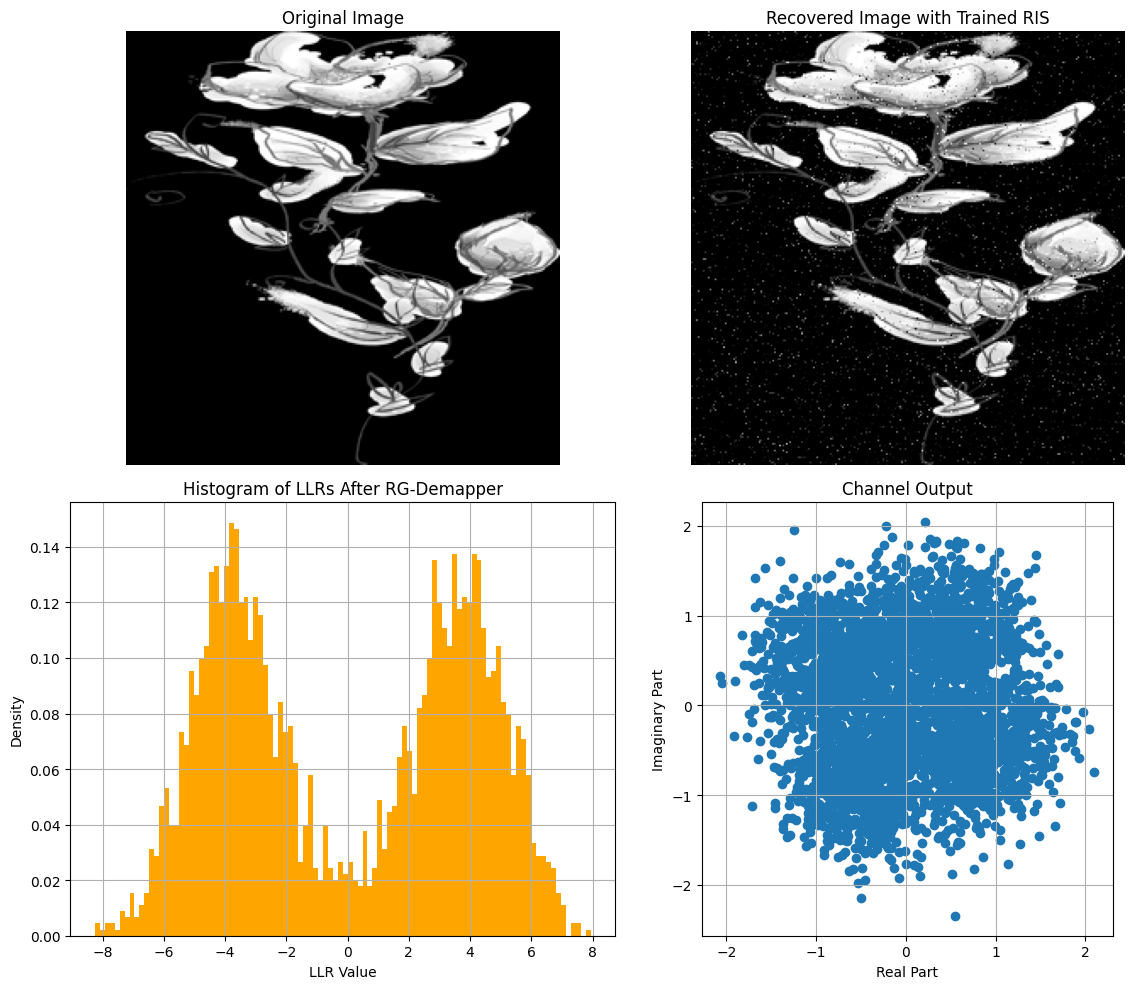

In [213]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Subplot 1: Original Image
axs[0, 0].imshow(img, cmap='gray')
axs[0, 0].axis('off')
axs[0, 0].set_title("Original Image")

# Subplot 2: Recovered Image
axs[0, 1].imshow(rec_img, cmap='gray')
axs[0, 1].axis('off')
axs[0, 1].set_title("Recovered Image with Trained RIS")

# Subplot 3: Histogram of LLRs
axs[1, 0].hist(llr_np, bins=100, density=True, alpha=1, color='orange')
axs[1, 0].grid(True)
axs[1, 0].set_title('Histogram of LLRs After RG-Demapper')
axs[1, 0].set_xlabel('LLR Value')
axs[1, 0].set_ylabel('Density')

# Subplot 4: Channel Output
axs[1, 1].scatter(tf.math.real(y), tf.math.imag(y))
axs[1, 1].set_aspect(1)
axs[1, 1].grid(True)
axs[1, 1].set_title('Channel Output')
axs[1, 1].set_xlabel('Real Part')
axs[1, 1].set_ylabel('Imaginary Part')

plt.tight_layout()
plt.show()


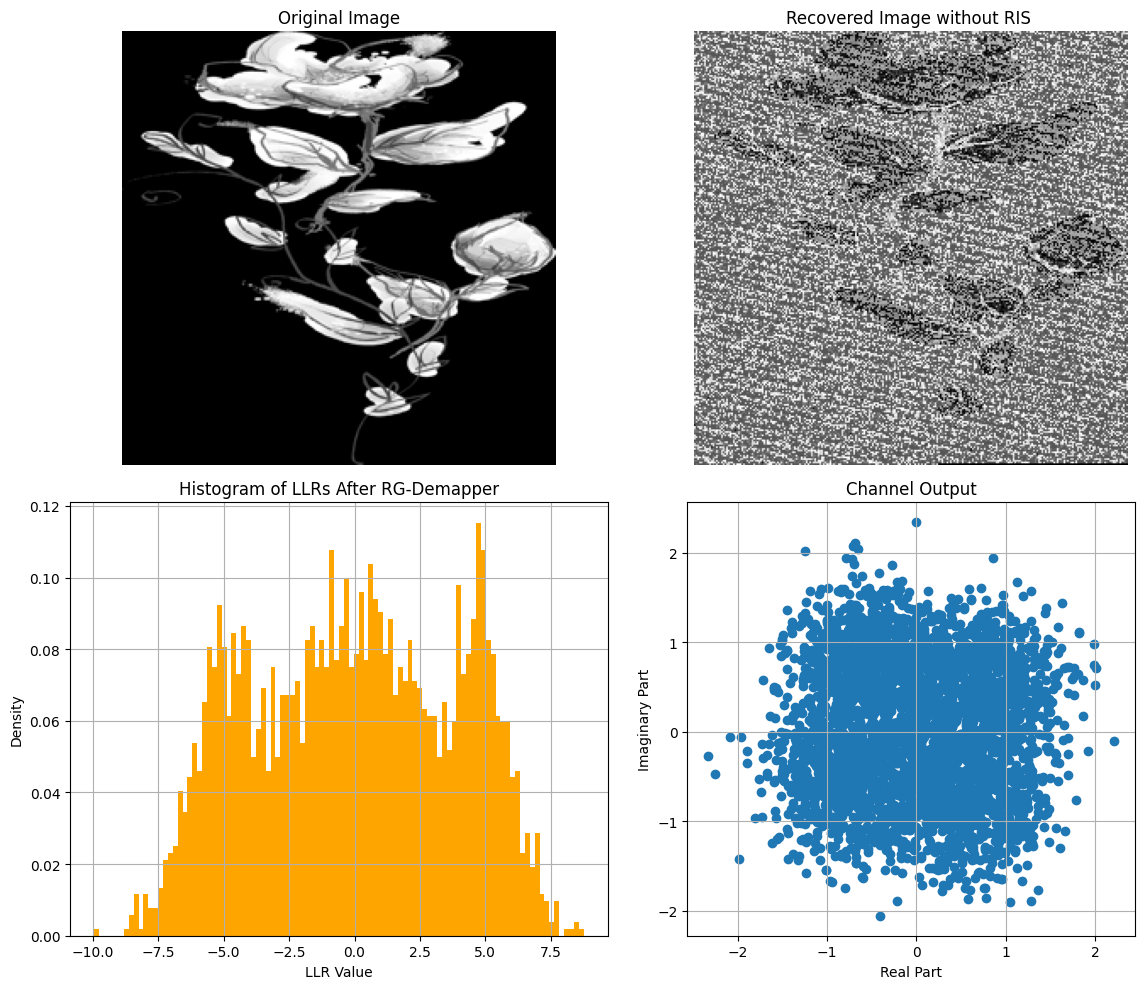

In [222]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Subplot 1: Original Image
axs[0, 0].imshow(img, cmap='gray')
axs[0, 0].axis('off')
axs[0, 0].set_title("Original Image")

# Subplot 2: Recovered Image
axs[0, 1].imshow(rec_img, cmap='gray')
axs[0, 1].axis('off')
axs[0, 1].set_title("Recovered Image without RIS ")

# Subplot 3: Histogram of LLRs
axs[1, 0].hist(llr_np, bins=100, density=True, alpha=1, color='orange')
axs[1, 0].grid(True)
axs[1, 0].set_title('Histogram of LLRs After RG-Demapper')
axs[1, 0].set_xlabel('LLR Value')
axs[1, 0].set_ylabel('Density')

# Subplot 4: Channel Output
axs[1, 1].scatter(tf.math.real(y), tf.math.imag(y))
axs[1, 1].set_aspect(1)
axs[1, 1].grid(True)
axs[1, 1].set_title('Channel Output')
axs[1, 1].set_xlabel('Real Part')
axs[1, 1].set_ylabel('Imaginary Part')

plt.tight_layout()
plt.show()